<a href="https://colab.research.google.com/github/ChaejinE/MyPytorch/blob/main/PyTorch_Tips_Details/j_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

# DataLoader
- num_workers : CPU -> GPU로 데이터를 로드할 떄 사용하는 프로세스 갯수
- num_workers는 기본적으로 0이다. 이는 data loading이 오직 main process에서만 발생하도록 하는 Synchronous 방법을 의미한다.
- num_workers > 0 조건이 되면 asynchronous하게 data loading이 가능해져 GPU 연산과 병렬적으로 data loading이 가능해지게 되어 병목문제를 개선할 수 있다.
  - I/O 연산으로 인한 병목현상 -> 코어를 적당히 나누어줘서 현사을 제거하는 것이 전체 학습 시간을 줄이는 데 도움이 된다.
  - 실험적으로 **num_workers = 4 x num_gpu**가 사용하기 좋았다는 의견이 있다.
  - 휴리스틱한 방법이므로 최적은 아니지만, 차용하여 사용한다. (num_workers = torch.cuda.device_count() * 4
- NVIDIA의 Conference에서도 **num_workers > 0 과 pin_memory=True 사용을 추천한다.**
# DataLoader pin_memory
- data loader 사용 시 옵션으로 **pin_memory = True**가 있다.
  - pin_memory = 고정된 메모리
- pin_memory = flase가 기본값이다.
- pin_memory가 True이면, CPU가 데이터를 GPU로 전달하는 속도를 향상 시킨다고한다.
  - **GPU를 사용하여 학습할 때 항상 사용한다고 봐도 된다.**
  - pin_memory는 CUDA와 연관되어있다.


![image](https://user-images.githubusercontent.com/69780812/140683291-a663ab56-de42-48c7-8e31-b1e2106fe406.png)


- HOST : CPU
- Device : GPU
- DataLoader를 통해 Host에서 Device로 데이터를 불러온다.
- 일반적으로는 페이징 기법을 통해 pageable memory(가상 메모리 관리 블록)을 관리한다. 이 가상 메모리는 실제 메모리 블록에 대응 되도록 되어있다.
  - CPU -> GPU로 데이터를 전달하기 위해서
  - 1. pageable memory에서 전달할 데이터들의 위치를 읽는다.
  - 2. 전달할 데이터를 pinned memory에 모아서 복사한다.
  - 3. pinned memory영역에 있는 데이터를 GPU로 전달한다.
- pin_memory = True 시, 1 -> 2 과정을 줄여 GPU 학습 시 효율적으로 데이터를 CPU -> GPU로 전달 한다.
  - pageable memory에서 전달할 데이터들을 확인하고, Pinned memory 영역으로 옮기지 않고 CPU메모리 영역에 GPU로 옮길 데이터를 바로 저장하는 방식이다.
  - DataLoader가 추가 연산 없이 이 영역에 있는 데이터들을 GPU로 바로 옮길 수 있다.
  - **page-locked memory**라고도 한다.
  

# GPU 사용 시 data.cuda(non_blocking=True)
- GPU 이용하여 학습 시 dataloader의 pin_memory 사용과 더불어 data의 cuda(non_blocking=True)는 일반적으로 반드시 사용하는 옵션이다.


```python
for i, (images) in enumerate(train_lodaer):
  data_time.update(time.time() - end)

  if args.gpu is not None:
    images = images.cuda(args.gpu, non_blocking=True)
  if torch.cuda.is_available():
    target = target.cuda(args.gpu, non_blocking=True)
```
- data를 cuda로 변환하면서 GPU 연산을 지원하도록 한다.
- non_blocking : True 시, CPU->GPU로 데이터를 전달하는 메커니즘과 연관된 옵션이다.
- pin_memory와 연관 지어서 ..
  - CPU -> GPU 복사는 pin memory에서 생성될 때 훨씬 빠르다.
  - CPU Tensor 및 스토리지는 pinned region에 데이터를 넣은 상태로 객체의 복사본을 전달하는 pin_memory 메서드를 사용한다.
  - 텐서 및 스토리지를 고정하면 asynchronous GPU 복사본을 사용할 수 있게된다.
  - 비동기식으로 GPU에 데이터 전달 기능을 추가하려면 **non_blocking = True**를 .to() 또는 cuda() 호출시 인자로 전달하면 된다.


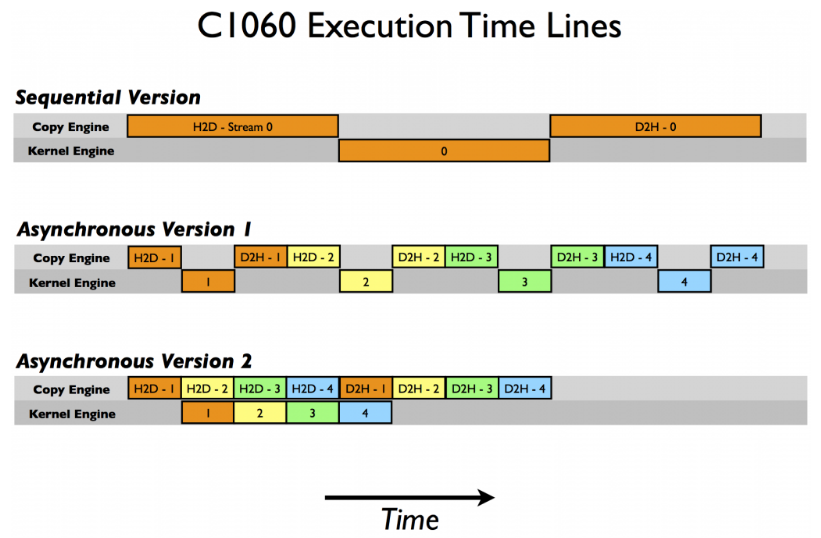

- 첫번째 그림이 동기식
- 두번째 세번째가 비동기식 방식이다.
- 동기식 방식은 CPU -> GPU로 데이터 전달이 끝나야 그 다음 연산이 진행되는 반면 비동기식은 데이터 전송과 GPU 연산이 동시에 발생할 수 있다.
- 이와 같은 방법을 통해 **데이터 전송**과 **계산**을 겹쳐서 비동기식으로 할 수 있으므로 연산 속도 향상에 도움을 준다.